In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "lampe01" # username from the json file
os.environ['KAGGLE_KEY'] = "0fe21bb583c2cd3230e9d928c96e27f7" # key from the json file
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/ReCirCor"

In [3]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install Ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip uninstall scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-1.0.2


In [7]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyaudioprocessing 1.1.13 requires scikit-learn==0.24.2; python_version <= "3.7", but you have scikit-learn 1.0.2 which is incompatible.


In [8]:
pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install pyAudioProcessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import itertools
import os
import sys
import pywt
import librosa
import sklearn
import scipy
import scipy.io
import scipy.io.wavfile
from scipy import signal
from scipy.stats import kurtosis, skew, tstd
from scipy.signal import periodogram, welch, butter, lfilter, freqz
from os import path
from pydub import AudioSegment
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, AlphaDropout, Activation, Flatten, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping,ReduceLROnPlateau,ProgbarLogger
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from pyAudioProcessing.extract_features import get_features

In [11]:
mdata = pd.read_csv('/content/drive/MyDrive/ReCirCor/training_data.csv')
input_dir = '/content/drive/MyDrive/ReCirCor/training_data/training_data'

In [12]:
#Gets all the txt files
def getfilenames(inputdir):
    Fname = list()
    Fname = sorted([fname for fname in os.listdir(inputdir) if not fname.startswith('.')and fname.endswith('.txt')])
    
    return Fname

In [13]:
#List of Labels - 0 for normal, 1 for murmur
labels = [0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,1]
len(labels)

23

In [14]:
#They were originally named differently and I have renamed and numbered them for ease of access.
#The michigan heart sound recordings are in mp3 format
#The recordings are converted to wav format for easy processing as most python libraries require the audio format to be wav.

def converttowav(filepath):
  destinationpath = filepath.split('.')[0] + '.wav'
  sound = AudioSegment.from_mp3(filepath)
  sound.export(destinationpath, format = "wav")

filepathslist = list()
for i in range(23):
  filepath = str(i+1) + '.mp3'
  converttowav(filepath)
  filepathslist.append(str(i+1)+'.wav')

In [15]:
#Creating an empty dataframe with columns to store filenames and the respective labels
dataframe = pd.DataFrame(columns = ['filename', 'labels'])

In [16]:
filepathslist

['1.wav',
 '2.wav',
 '3.wav',
 '4.wav',
 '5.wav',
 '6.wav',
 '7.wav',
 '8.wav',
 '9.wav',
 '10.wav',
 '11.wav',
 '12.wav',
 '13.wav',
 '14.wav',
 '15.wav',
 '16.wav',
 '17.wav',
 '18.wav',
 '19.wav',
 '20.wav',
 '21.wav',
 '22.wav',
 '23.wav']

In [17]:
labels

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]

In [18]:
#Get only murmur recordings
def getrecmur(inputdir):
    fname = getfilenames(inputdir)
    items = []
    rinfo = []
    recf = []
    labels = []
    recfile = []
    for i in fname:
        i = inputdir + '/' + i
        with open(i, 'r') as f:
            content = f.readlines()
        numloc = int(content[0].split(' ')[1])
        for i in range(numloc):
            for p in range(len(content)):
                t = content[p].split('\n')
                for it in t:
                    if it.startswith('#Murmur:'):
                        tar = it.split(': ')[1]
                        if tar == 'Present':
                          recinfo = content[i+1].split(' ')
                          rinfo.append(recinfo)
                          l = 1
                          labels.append(l)
                        elif tar == 'Absent':
                          recinfo = content[i+1].split(' ')
                          rinfo.append(recinfo)
                          l = 0
                          labels.append(l)
    for items in rinfo:
        for i in range(len(items)):
            if items[i].endswith('.wav'):
                recfile = input_dir + '/' + items[i]
        recf.append(recfile)
    return rinfo, recf, labels

rin, ref, label = getrecmur(input_dir)

In [19]:
for i in range(100):
  filepathslist.append(ref[i])
  labels.append(label[i])

In [20]:
#Inserting filename and label values into dataframe
dataframe['filename'] = filepathslist
dataframe['labels'] = labels

In [21]:
dataframe

,filename,labels
0,1.wav,0
1,2.wav,0
2,3.wav,0
3,4.wav,0
4,5.wav,0
...,...,...
118,/content/drive/MyDrive/ReCirCor/training_data/...,0
119,/content/drive/MyDrive/ReCirCor/training_data/...,0
120,/content/drive/MyDrive/ReCirCor/training_data/...,0
121,/content/drive/MyDrive/ReCirCor/training_data/...,1


In [22]:
#Computing Features - 

psdlist = list()
rmslist = list()
zcrlist = list()

#Discrete Wavelet Transform - 
#Output is a dict of lists - 
def computeDWTs(x):
    #approximation and detail coefficients
    res = np.array([])
    ca, cd = pywt.dwt(x, 'db8')
    #Compute mean, stdev, skew, kurtosis
    camean = np.mean(ca)
    res = np.hstack((res,camean))
    castdev = tstd(ca)
    res = np.hstack((res,castdev))
    caskew = skew(ca)
    res = np.hstack((res,caskew))
    cakurtosis = kurtosis(ca)
    res = np.hstack((res,cakurtosis))
    cdmean = np.mean(cd)
    res = np.hstack((res,cdmean))
    cdstdev = tstd(cd)
    res = np.hstack((res,cdstdev))
    cdskew = skew(cd)
    res = np.hstack((res,cdskew))
    cdkurtosis = kurtosis(cd)
    res = np.hstack((res, cdkurtosis))
    coeffnamelist = ['camean', 'castdev', 'caskew', 'cakurtosis', 'cdmean', 'cdstdev', 'cdskew', 'cdkurtosis']
    dwtlist = getdwtlist(res, coeffnamelist)
    return dwtlist

#Computing the Spectral Entropy of the signal - Shannon Entropy of the Power Spectral Density (PSD) of the data
def SpectralEntropy(Signal, SampleRate, method = 'fft', nperseg = None, normalize = False):
    Signal = np.array(Signal)
    if method == 'fft':
      _, psd = periodogram(Signal, SampleRate)
    elif method == 'welch':
      _, psd = welch(Signal, SampleRate, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se

#Computing the Power Spectral Density(PSD) of signal - 
#Output is a list - 
def computepsd(x):
    freq, psd = signal.welch(x)
    psdlist.append(psd)
    return psdlist

#Computing Mel-frequency cepstral coefficients, Gammatone frequency cepstral coefficients, RMS Energy, Zero-crossing rate, mean, variance, skew, and kurtosis of the signal
#Output is a dict of lists - 
def computeMFCC(x, sr):
    mfccs = np.mean(librosa.feature.mfcc(y = x, sr = sr, n_mfcc = 13).T, axis = 0)
    mfccdict = getmfcclist(mfccs)
    return mfccdict

#Computing the gammatone frequency cepstral coefficients - 
#Output is a dict of lists - 
def computeGFCC(file_name):
    gfcc = get_features(file=file_name, feature_names=["gfcc"])
    dictgfcc = getgfcclist(gfcc, file_name)
    return dictgfcc

#Computing rms, zcr, and general stats - 

#Output is a list - 
def computeRMSEn(x):
    rmsen = np.mean(librosa.feature.rms(x, frame_length=2048, hop_length=1024, center=True).T, axis = 0)
    rmslist.append(rmsen[0])
    return rmslist

#Output is a list - 
def computeZCR(x):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y = x, frame_length=2048, hop_length=1024).T, axis = 0)
    zcrlist.append(zcr[0])
    return zcrlist

#Output is a dict of lists - 
def computestats(x):
#Mean, Variance, Skew, Kurtosis
    stats = []
    me = np.mean(x)
    stats.append(me)
    variance = np.var(x)
    stats.append(variance)
    sk = skew(x)
    stats.append(sk)
    kurt = kurtosis(x)
    stats.append(kurt)
    coeffnamelist = ['mean', 'variance', 'skew', 'kurtosis']
    statlist = getstatlist(stats, coeffnamelist)
    return statlist

In [23]:
#Making lists for each feature - 

dictofmfcc = defaultdict(list)
dictofgfccs = defaultdict(list)
dictofdwt = defaultdict(list)
dictofstat = defaultdict(list)

def getmfcclist(mfccs):
  for i in range(13):
    item = mfccs[i]
    dictofmfcc[f"mfcc_{i}"].append(item)
  return dictofmfcc

def getgfcclist(gfccs, filename):
  for i in range(44):
    fn = gfccs['audio'][filename]['feature_names'][i]
    item = gfccs['audio'][filename]['features'][i]
    dictofgfccs[fn].append(item)
  return dictofgfccs

def getdwtlist(res, coefflist):
  for i in range(8):
    fn = coefflist[i]
    item = res[i]
    dictofdwt[fn].append(item)
  return dictofdwt

def getstatlist(res, coefflist):
  for i in range(4):
    fn = coefflist[i]
    item = res[i]
    dictofstat[fn].append(item)
  return dictofstat

In [24]:
#Function to extract the required features
def extractfeatures(file_name, x, sr, *, mfcc: bool = False, dwt: bool = False, spectral_entropy: bool = False, psd: bool = False, gfcc: bool = False, rmse: bool = False, zcr: bool = False, stats: bool = False):
    finalfeatures = np.array([])
    if mfcc:
        mfccs = computeMFCC(x, sr)
    if dwt:
        dwtlist = computeDWTs(x)
    if spectral_entropy:
        specen = SpectralEntropy(x, sr)
    #if psd:
        #psds = computepsd(x)
        #psds, 
    if gfcc:
        gfccs = computeGFCC(file_name)
    if rmse:
        rmselist = computeRMSEn(x)
    if zcr:
        zcrslist = computeZCR(x)
    if stats:
        statslist = computestats(x)
    return mfccs, dwtlist, gfccs, rmselist, zcrslist, statslist

In [25]:
#loads audio and extracts required features
def load_file_data(file_names, duration=5, sr = 4000):
    input_length=sr*duration
    notfeatures = []
    for file_name in file_names:
        try:
            #sound_file = folder + '/' + file_name
            sound_file = file_name
            print ("load file ",sound_file)
            x, sr = librosa.load(sound_file,duration=duration,res_type='kaiser_fast')
            dur = librosa.get_duration(y=x, sr=sr)
            #Padding audio signal
            if (round(dur) < duration):
                print ("fixing audio length:", file_name)
                y = librosa.util.fix_length(x, input_length)
            dictmfcc, dictdwt, dictgfcc, listrms, listzcr, dictstats = extractfeatures(sound_file, x, sr, mfcc = True, dwt = True, gfcc = True, rmse = True, zcr = True, stats = True)           
        except Exception as e:
            print(e)
            #notfeatures = np.asarray(features, dtype=np.float32)
            #listpsd,
    return dictmfcc, dictdwt, dictgfcc, listrms, listzcr, dictstats

In [26]:
dictmfcc, dictdwt, dictgfcc, listrms, listzcr, dictstats = load_file_data(filepathslist)

load file  1.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 1.wav
load file  2.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 2.wav
load file  3.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 3.wav
load file  4.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 4.wav
load file  5.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 5.wav
load file  6.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 6.wav
load file  7.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 7.wav
load file  8.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 8.wav
load file  9.wav

        
 Extracting features gfcc 

        
Computing features for file 1 of 1 : 9.wav
load file  10.wav

        
 Extracti

In [27]:
dictmfcc

defaultdict(list,
            {'mfcc_0': [-467.0059,
              -547.4695,
              -493.46152,
              -477.09448,
              -501.43863,
              -516.0458,
              -483.41226,
              -493.143,
              -489.08957,
              -465.3647,
              -446.08536,
              -435.32278,
              -499.64505,
              -478.02737,
              -471.603,
              -465.18365,
              -437.15393,
              -478.02737,
              -478.039,
              -473.92462,
              -487.73807,
              -487.0935,
              -458.8938,
              -424.85394,
              -441.25238,
              -449.18903,
              -434.91275,
              -411.37582,
              -426.07895,
              -374.74002,
              -387.59888,
              -435.97894,
              -412.92813,
              -365.8598,
              -399.26483,
              -500.9404,
              -466.29666,
              -508.43777

In [28]:
featuredict = [dictmfcc, dictdwt, dictgfcc, dictstats]
featurelist = [listrms, listzcr]
namelist = ['rms', 'zcr']

In [29]:
dictgfcc

defaultdict(list,
            {'gfcc_1_mean': [-0.16187522445511107,
              -0.21075935105194285,
              -0.22757106838849558,
              -0.18524406692515755,
              -0.2262000582433398,
              -0.3256886019220553,
              -0.3737978237791193,
              -0.32647062433575436,
              -0.3738772961920753,
              -0.2129098669778752,
              -0.29166281710424696,
              -0.3003657084913589,
              -0.17996443292958592,
              -0.20105399066045723,
              -0.2365983336316623,
              -0.18717073260621048,
              -0.3179706938171137,
              -0.20105399066045723,
              -0.24656032955920681,
              -0.19740943731906208,
              -0.17467746566433878,
              -0.32393555781783984,
              -0.1816284560275009,
              -0.094053374638219,
              -0.04842523724376528,
              -0.06777568421511763,
              -0.08621606153755267,
      

In [30]:
#for i in featuredict:
 # key = i.keys()
  #for j in key:
   # val = i[j]
    #fdf[j] = val

#listnames = ['psd', 'rms', 'zcr']

#j = 0
#for i in featurelist:
 # col = listnames[j]
  #fdf[col] = i
  #j = j+1

In [183]:
def getfeaturedataframe(dictfeat, listfeat, listnames):
  Featuredataframe = pd.DataFrame(columns = ['Wav ID'])
  Featuredataframe['Wav ID'] = filepathslist
  for i in dictfeat:
    key = i.keys()
    for j in key:
      val = i[j]
      Featuredataframe[j] = val
  
  k = 0
  for i in listfeat:
    col = listnames[k]
    Featuredataframe[col] = i
    k = k+1
  
  Featuredataframe['Labels'] = labels
  return Featuredataframe

In [184]:
Featuresdf = getfeaturedataframe(featuredict, featurelist, namelist)

In [33]:
Featuresdf

,Wav ID,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,gfcc_20_std,gfcc_21_std,gfcc_22_std,mean,variance,skew,kurtosis,rms,zcr,Labels
0,1.wav,-467.005890,30.030811,28.432730,25.964861,22.885386,19.493237,16.082209,12.900651,10.124111,...,0.019222,0.017984,0.014769,-0.000917,0.012629,-0.025461,32.262532,0.054259,0.006085,0
1,2.wav,-547.469482,46.999607,43.693832,38.678108,32.594315,26.166515,20.074808,14.848034,10.796354,...,0.020107,0.018575,0.015226,-0.000917,0.003868,-0.021340,10.566409,0.038230,0.007311,0
2,3.wav,-493.461517,45.738007,43.258198,39.384975,34.471062,28.942736,23.245995,17.793795,12.922318,...,0.022423,0.020262,0.016092,-0.000919,0.010944,-0.011584,12.579745,0.067872,0.009874,0
3,4.wav,-477.094482,41.272854,37.960964,33.038132,27.242409,21.343788,15.981769,11.558811,8.211711,...,0.020249,0.018572,0.014939,-0.000915,0.012200,-0.023764,21.344287,0.060943,0.007378,0
4,5.wav,-501.438629,40.631420,38.138077,34.408627,29.948507,25.144924,20.404640,16.023802,12.308167,...,0.023476,0.021733,0.017771,-0.000907,0.010723,-0.006688,12.174772,0.065149,0.017013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,/content/drive/MyDrive/ReCirCor/training_data/...,-437.950623,191.480728,58.741390,-19.562468,-10.323786,22.026686,20.232861,-0.922164,-2.077124,...,0.005047,0.004715,0.004473,0.000654,0.002771,-0.043377,162.891967,0.033764,0.021087,0
119,/content/drive/MyDrive/ReCirCor/training_data/...,-417.383240,180.014252,42.974319,-32.841137,-15.526951,23.816383,22.939501,-0.862390,-3.459703,...,0.004413,0.004191,0.003739,0.000791,0.002875,-0.978344,187.383524,0.026118,0.043624,0
120,/content/drive/MyDrive/ReCirCor/training_data/...,-457.919678,150.422745,45.990993,-16.007586,-7.141266,22.015718,23.160526,5.222690,0.643182,...,0.004371,0.004268,0.003879,-0.000994,0.001008,-2.355982,555.089578,0.013615,0.032873,0
121,/content/drive/MyDrive/ReCirCor/training_data/...,-460.233948,202.673080,65.113022,-17.807854,-11.555839,21.392519,22.149319,2.693578,1.416682,...,0.005372,0.004709,0.004327,-0.000015,0.001693,1.534309,16.621299,0.033618,0.020218,1


In [34]:
for i in Featuresdf.columns:
  print(i)

Wav ID
mfcc_0
mfcc_1
mfcc_2
mfcc_3
mfcc_4
mfcc_5
mfcc_6
mfcc_7
mfcc_8
mfcc_9
mfcc_10
mfcc_11
mfcc_12
camean
castdev
caskew
cakurtosis
cdmean
cdstdev
cdskew
cdkurtosis
gfcc_1_mean
gfcc_2_mean
gfcc_3_mean
gfcc_4_mean
gfcc_5_mean
gfcc_6_mean
gfcc_7_mean
gfcc_8_mean
gfcc_9_mean
gfcc_10_mean
gfcc_11_mean
gfcc_12_mean
gfcc_13_mean
gfcc_14_mean
gfcc_15_mean
gfcc_16_mean
gfcc_17_mean
gfcc_18_mean
gfcc_19_mean
gfcc_20_mean
gfcc_21_mean
gfcc_22_mean
gfcc_1_std
gfcc_2_std
gfcc_3_std
gfcc_4_std
gfcc_5_std
gfcc_6_std
gfcc_7_std
gfcc_8_std
gfcc_9_std
gfcc_10_std
gfcc_11_std
gfcc_12_std
gfcc_13_std
gfcc_14_std
gfcc_15_std
gfcc_16_std
gfcc_17_std
gfcc_18_std
gfcc_19_std
gfcc_20_std
gfcc_21_std
gfcc_22_std
mean
variance
skew
kurtosis
rms
zcr
Labels


In [185]:
Featuresdf.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,66,67,68,69,70,71]]

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,cdmean,cdstdev,cdskew,cdkurtosis,mean,variance,skew,kurtosis,rms,zcr
0,-467.005890,30.030811,28.432730,25.964861,22.885386,19.493237,16.082209,12.900651,10.124111,7.844525,...,1.553085e-10,0.000010,0.434322,21.286016,-0.000917,0.012629,-0.025461,32.262532,0.054259,0.006085
1,-547.469482,46.999607,43.693832,38.678108,32.594315,26.166515,20.074808,14.848034,10.796354,7.993905,...,-6.057366e-11,0.000010,-0.028641,0.115152,-0.000917,0.003868,-0.021340,10.566409,0.038230,0.007311
2,-493.461517,45.738007,43.258198,39.384975,34.471062,28.942736,23.245995,17.793795,12.922318,8.862035,...,-2.933286e-10,0.000011,-0.002742,0.088968,-0.000919,0.010944,-0.011584,12.579745,0.067872,0.009874
3,-477.094482,41.272854,37.960964,33.038132,27.242409,21.343788,15.981769,11.558811,8.211711,5.855572,...,-3.238879e-10,0.000010,-0.021068,0.166512,-0.000915,0.012200,-0.023764,21.344287,0.060943,0.007378
4,-501.438629,40.631420,38.138077,34.408627,29.948507,25.144924,20.404640,16.023802,12.308167,9.368141,...,5.632778e-09,0.000041,21.326271,12476.963103,-0.000907,0.010723,-0.006688,12.174772,0.065149,0.017013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-437.950623,191.480728,58.741390,-19.562468,-10.323786,22.026686,20.232861,-0.922164,-2.077124,14.634414,...,-1.514604e-10,0.000011,-40.745846,17914.741645,0.000654,0.002771,-0.043377,162.891967,0.033764,0.021087
119,-417.383240,180.014252,42.974319,-32.841137,-15.526951,23.816383,22.939501,-0.862390,-3.459703,13.900631,...,-3.884535e-10,0.000036,43.298809,19417.587974,0.000791,0.002875,-0.978344,187.383524,0.026118,0.043624
120,-457.919678,150.422745,45.990993,-16.007586,-7.141266,22.015718,23.160526,5.222690,0.643182,11.459326,...,1.697157e-10,0.000002,30.315109,12426.173065,-0.000994,0.001008,-2.355982,555.089578,0.013615,0.032873
121,-460.233948,202.673080,65.113022,-17.807854,-11.555839,21.392519,22.149319,2.693578,1.416682,17.436470,...,6.455501e-10,0.000022,-40.284664,18223.629132,-0.000015,0.001693,1.534309,16.621299,0.033618,0.020218


In [215]:
x = Featuresdf.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12,13]].values

In [216]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [56]:
x[0]

array([-4.67005890e+02,  3.00308113e+01,  2.84327297e+01,  2.59648609e+01,
        2.28853855e+01,  1.94932365e+01,  1.60822086e+01,  1.29006510e+01,
        1.01241112e+01,  7.84452534e+00,  6.07554245e+00,  4.77014351e+00,
        3.84459591e+00, -1.29622279e-03,  1.58921060e-01, -2.54643075e-02,
        3.22669512e+01,  1.55308516e-10,  9.52724177e-06,  4.34321553e-01,
        2.12860157e+01, -1.61875224e-01,  1.02327325e-01, -5.23552404e-02,
        3.63659098e-02, -1.95386309e-02,  1.55912190e-02, -1.01840292e-02,
        7.99169697e-03, -6.99606236e-03,  6.76977217e-03, -4.94390511e-03,
        4.94064311e-03, -2.56631274e-03,  8.29047045e-04,  1.96949235e-03,
       -4.91984160e-03,  7.91820246e-03, -1.03488413e-02,  1.23279388e-02,
       -1.26719323e-02,  1.21715521e-02, -1.02262373e-02,  1.59924680e-01,
        1.13781959e-01,  7.30252457e-02,  5.77481894e-02,  2.93120400e-02,
        1.89542648e-02,  1.46088178e-02,  1.05500577e-02,  1.22120643e-02,
        1.18308337e-02,  

In [37]:
y = dataframe['labels']

In [38]:
pip uninstall yellowbrick

Found existing installation: yellowbrick 1.5
Uninstalling yellowbrick-1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/yellowbrick-1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/yellowbrick/*
Proceed (y/n)? y
  Successfully uninstalled yellowbrick-1.5


In [39]:
pip install -U yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyaudioprocessing 1.1.13 requires scikit-learn==0.24.2; python_version <= "3.7", but you have scikit-learn 1.0.2 which is incompatible.


In [47]:
pip uninstall scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-1.0.2


In [48]:
pip install scikit-learn==0.24.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.24.0-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.
pyaudioprocessing 1.1.13 requires scikit-learn==0.24.2; python_version <= "3.7", but you have scikit-learn 0.24.0 which is incompatible.


In [ ]:
#pip uninstall matplotlib

In [43]:
#pip install matplotlib==3.3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from yellowbrick import features

In [50]:
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D

In [51]:
import matplotlib.pyplot as plt

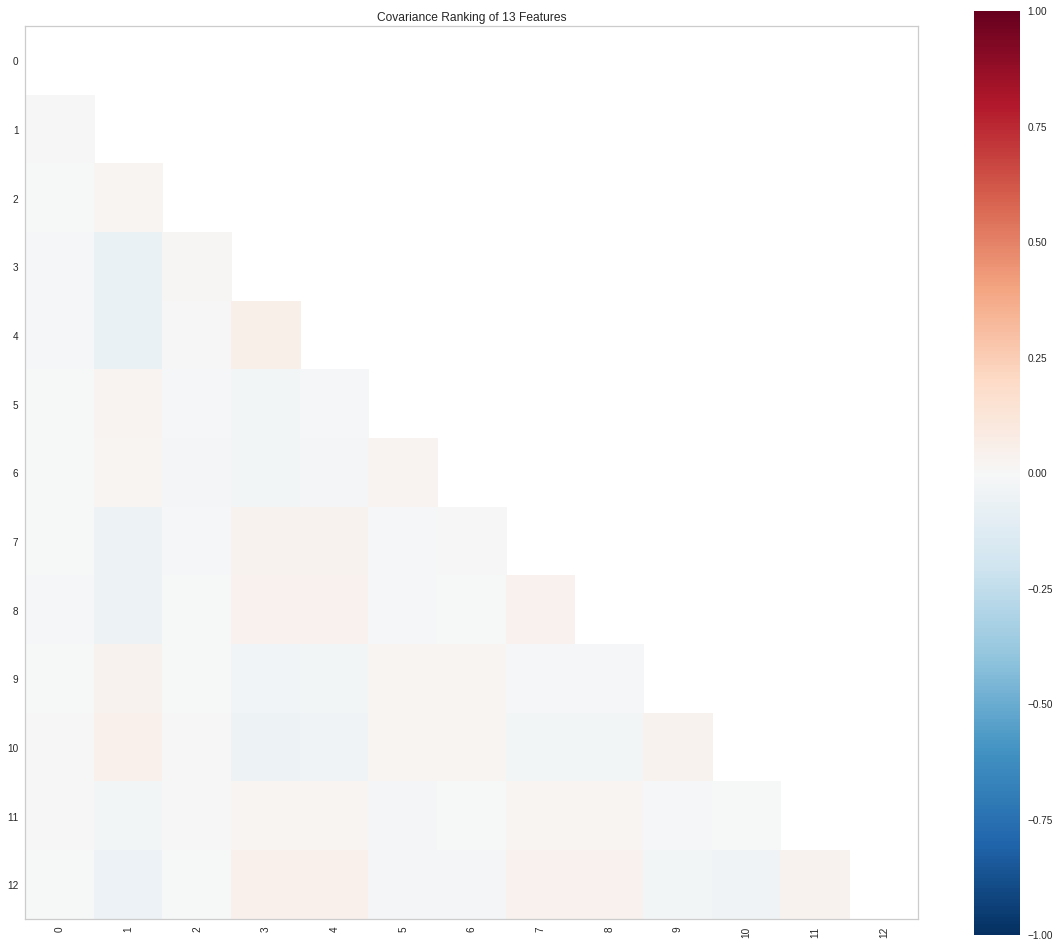

<AxesSubplot:title={'center':'Covariance Ranking of 13 Features'}>

In [217]:
visualizer = Rank2D(algorithm='covariance')
plt.figure(figsize=[20, 17])
visualizer.fit(x, y)           # Fit the data to the visualizer
visualizer.transform(x)        # Transform the data
visualizer.show()

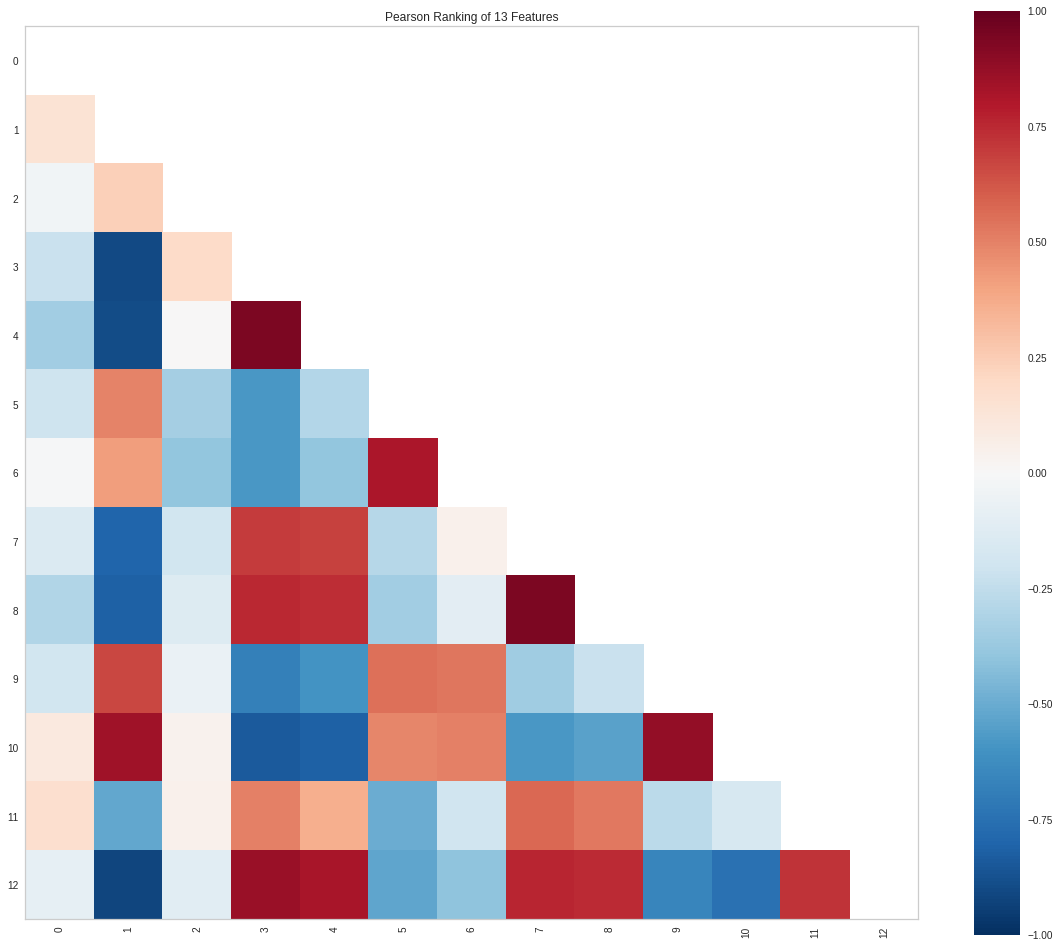

<AxesSubplot:title={'center':'Pearson Ranking of 13 Features'}>

In [218]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')
plt.figure(figsize=[20, 17])
visualizer.fit(x, y)           # Fit the data to the visualizer
visualizer.transform(x)        # Transform the data
visualizer.show()

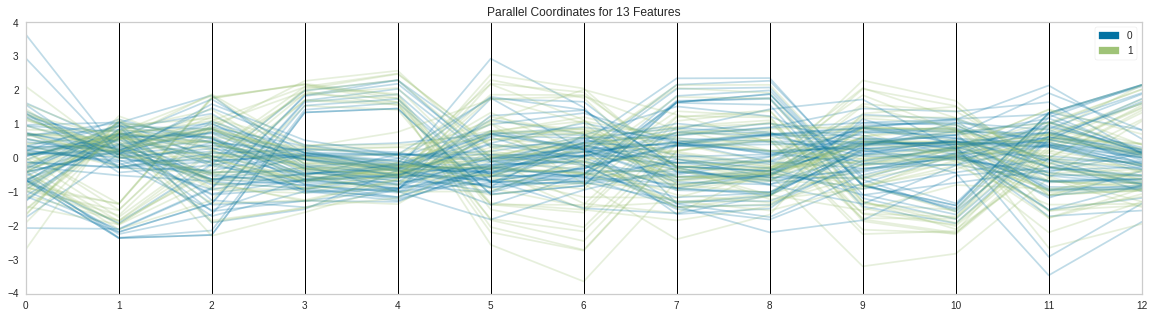

<AxesSubplot:title={'center':'Parallel Coordinates for 13 Features'}>

In [219]:
from yellowbrick.features import ParallelCoordinates
classes = ['0', '1']
# Instantiate the visualizer
visualizer = visualizer = ParallelCoordinates(
    classes=classes, normalize = 'standard')
plt.figure(figsize=[20, 5])
visualizer.fit(x, y)     
visualizer.transform(x)   
visualizer.poof()

In [220]:
from yellowbrick.features import RadViz

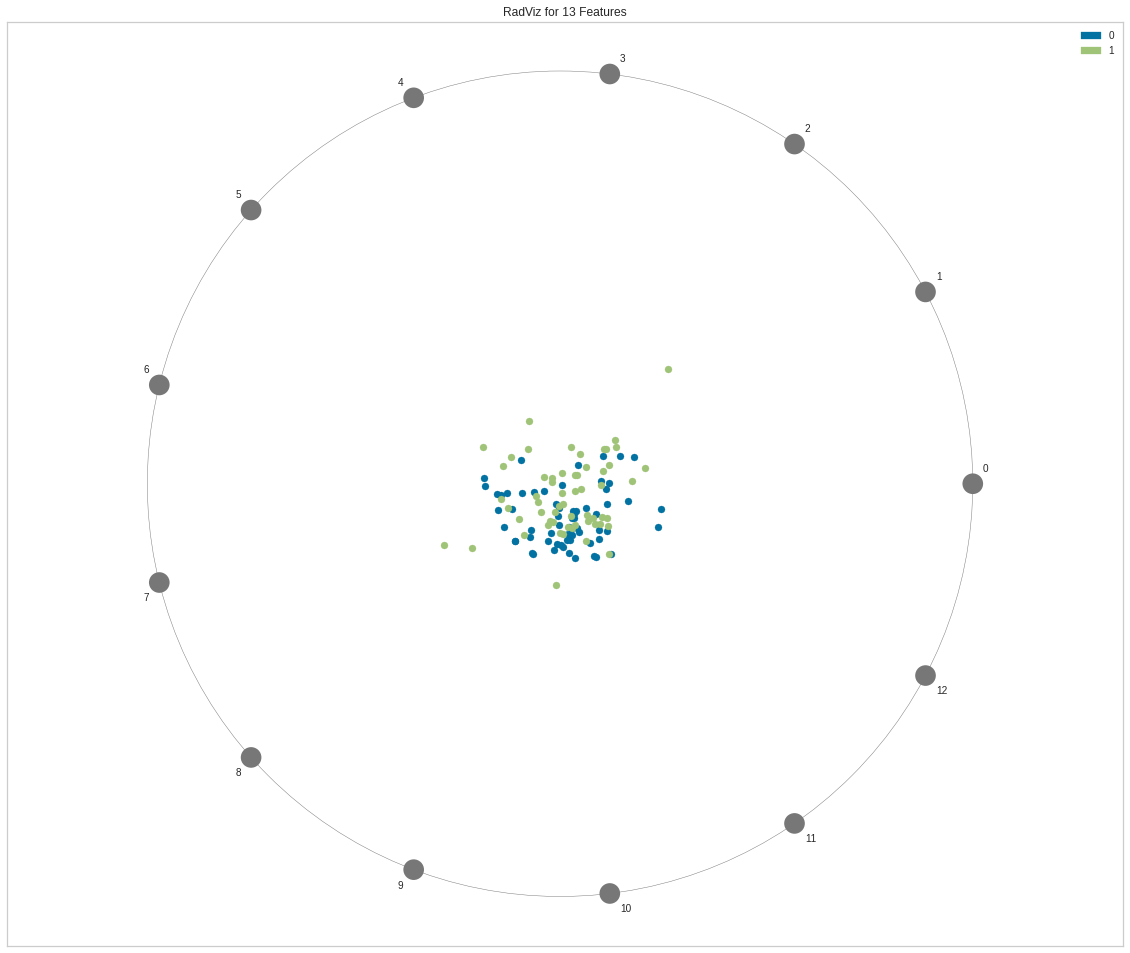

<AxesSubplot:title={'center':'RadViz for 13 Features'}>

In [221]:
classes = ["0", "1"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes)
plt.figure(figsize=[20, 17])
visualizer.fit(x, y)           # Fit the data to the visualizer
visualizer.transform(x)        # Transform the data
visualizer.show()     

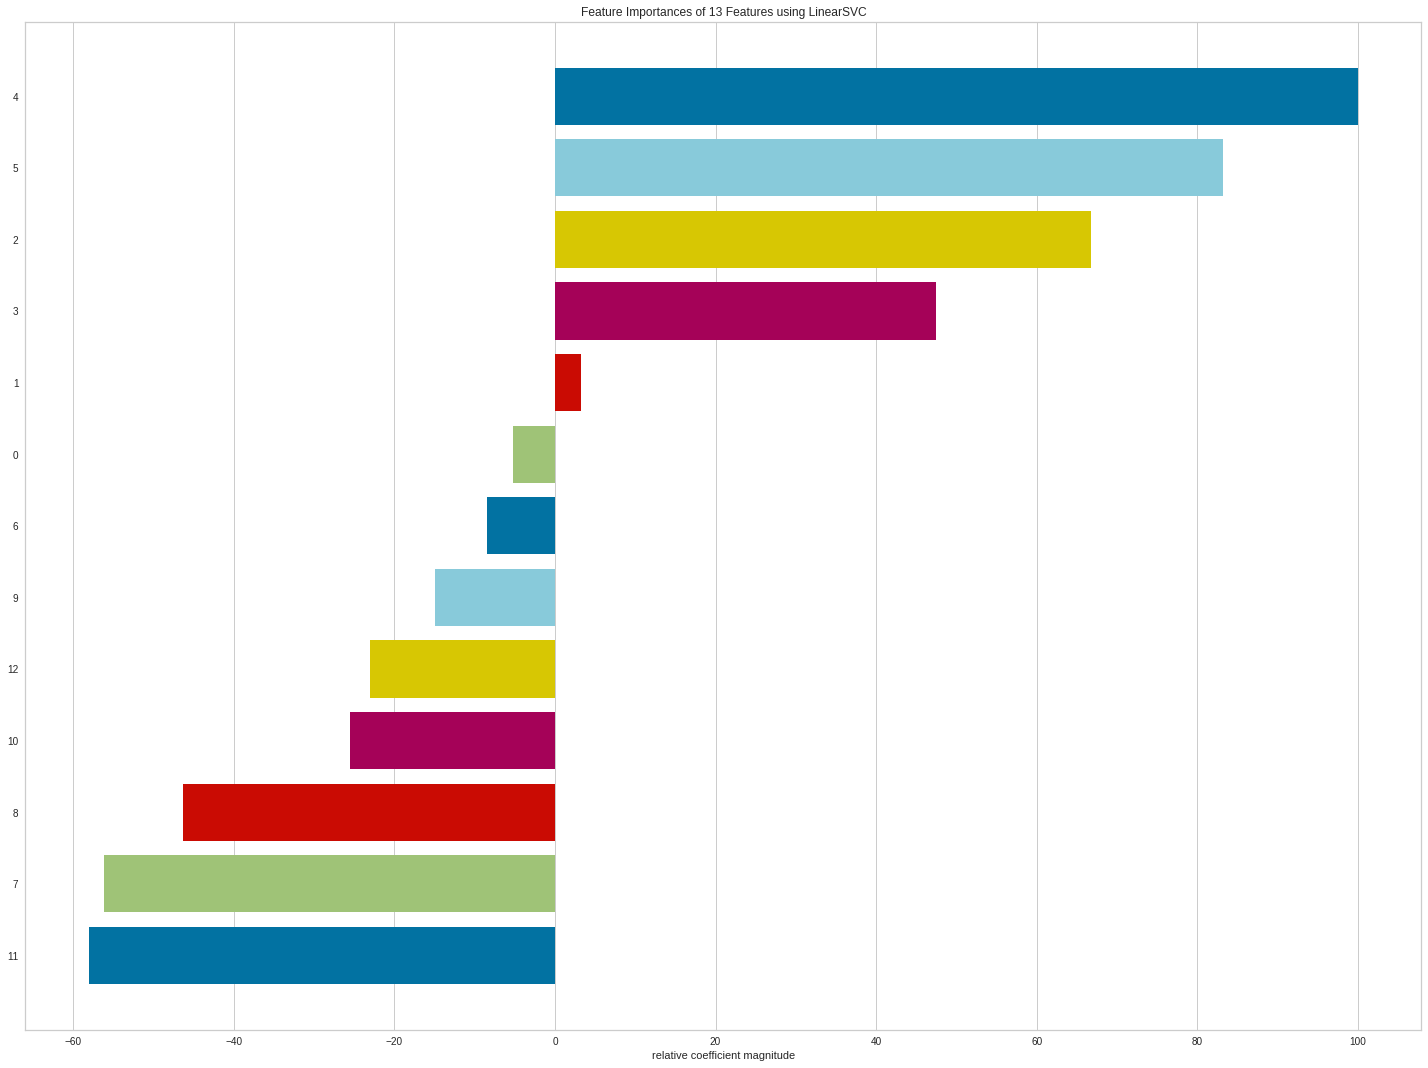

<AxesSubplot:title={'center':'Feature Importances of 13 Features using LinearSVC'}, xlabel='relative coefficient magnitude'>

In [222]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from yellowbrick.features import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure(figsize=[20, 15])
ax = fig.add_subplot()

viz = FeatureImportances(LinearSVC(penalty='l2', loss='hinge'), ax=ax)
viz.fit(x, y)
viz.poof()

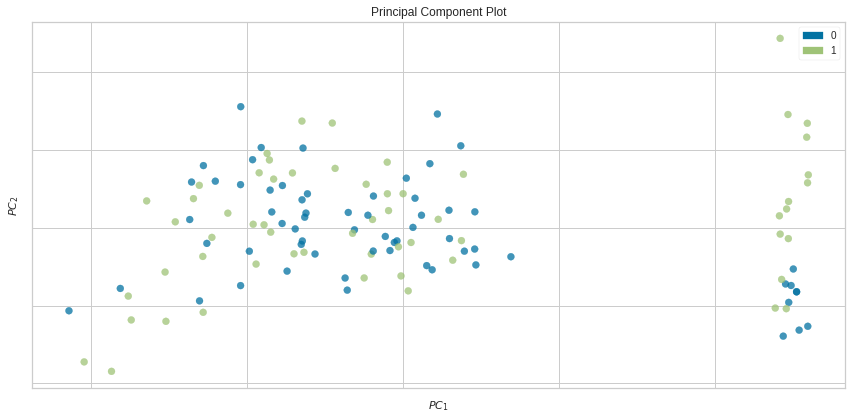

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [223]:
from yellowbrick.features import PCADecomposition

fig, ax = plt.subplots(1, figsize=(12, 6))
cmap = y.map(lambda v: "steelblue" if v else "lightgray")
vzr = PCADecomposition(color=cmap)
vzr.fit_transform(x, y)
vzr.poof()

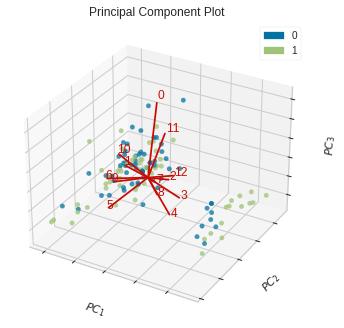

<Figure size 2880x1440 with 0 Axes>

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [224]:
from yellowbrick.features import PCA
vzr1 = PCA(scale=True, proj_features=True, projection=3)
fig = plt.figure(figsize=[40,20])
vzr1.fit_transform(x, y)
vzr1.poof()

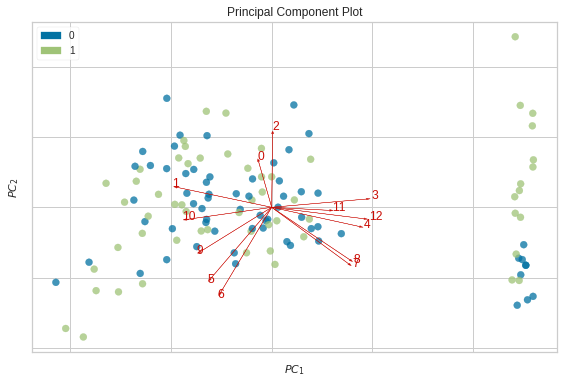

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [225]:
visualizer = PCA(scale=True, proj_features=True)
visualizer.fit_transform(x, y)
visualizer.show()

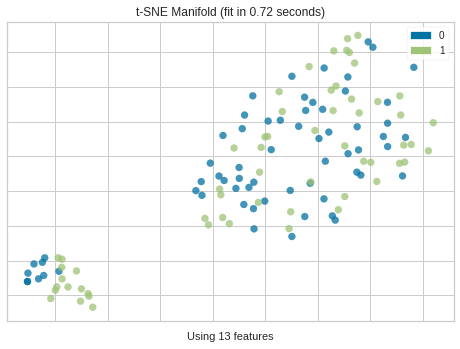

<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:title={'center':'t-SNE Manifold (fit in 0.72 seconds)'}, xlabel='Using 13 features'>

In [226]:
from yellowbrick.features import Manifold
from yellowbrick.datasets import load_occupancy
classes = ["0", "1"]
# Instantiate the visualizer
viz = Manifold(manifold="tsne", classes=classes, target = "discrete")
fig = plt.figure(figsize=[20, 15])
viz.fit_transform(x, y) # Fit the data to the visualizer
viz.show() 

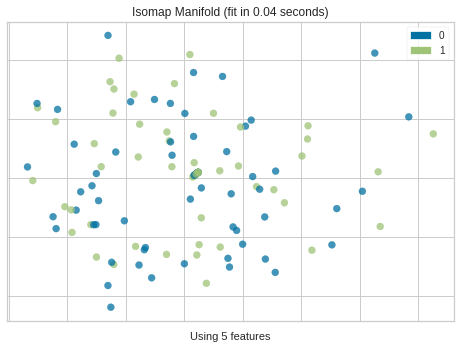

<AxesSubplot:title={'center':'Isomap Manifold (fit in 0.04 seconds)'}, xlabel='Using 5 features'>

In [228]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from yellowbrick.features import Manifold
# Create a pipeline
model = Pipeline([
("selectk", SelectKBest(k=5, score_func=f_classif)),
("viz", Manifold(manifold="isomap", n_neighbors=10, classes=classes)),
])
model.fit_transform(x, y) # Fit the data to the model
model.named_steps['viz'].show()